In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_csv = ['graduation', 'ap2010','attendance', 'class_size', 'sat_results', 'demographics']
data_txt = ['d75_final', 'gened_final']
dataset = {}

# Read In Data

In [2]:
# load dataframes into the dataset dictionary
for data in data_csv:
    if data == 'attendance':
        encoding = 'utf-8'
    else:
        encoding = 'windows-1252'
    dataframe = pd.read_csv(data + '.csv', encoding = encoding)
    dataset[data] = dataframe
for data in data_txt:
    survey = []
    file = open(data + '.txt','r')
    dataframe = pd.read_table(file,encoding = 'windows-1252')
    survey.append(dataframe)
    file.close()
survey = pd.concat(survey, axis = 0)
dataset['survey'] = survey

Now that the files have been opened in a dataframe and put in the dataset dictionary, it's time to clean the dataset to only use the columns we need. The DBN column is unique in all dataframes so it will be used as a primary key in our analysis



# Remove Impertinent Survey Columns

In [3]:
# create a list of columns to keep in the survey dataframe
# create a DBN column for uniformity
dataset['survey']['DBN'] = dataset['survey']['dbn']
survey_list  = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
dataset['survey'] = dataset['survey'][survey_list] 

# Clean Attendance and Class_size

In [4]:
dataset['attendance']['DBN'] = dataset['attendance']['dbn'] # Replace dbn column name with DBN
dataset['attendance'].drop(columns = 'dbn')
dataset['class_size']['CSD'] = dataset['class_size']['CSD'] .apply(lambda string: str(string).zfill(2))
dataset['class_size']['DBN'] = dataset['class_size']['CSD'] + dataset['class_size']['SCHOOL CODE']  

# Convert sat_results Columns to Numeric

In [5]:
cols = list(dataset["sat_results"].columns)[3:]
total = []
for c in cols:
    dataset["sat_results"][c] = pd.to_numeric(dataset["sat_results"][c], errors="coerce")
    total.append(dataset["sat_results"][c])

# Sum up the columns in cols to get total sat score
dataset['sat_results']['sat_score'] = sum(total)

# Filter Datasets

In [6]:
class_size = dataset["class_size"]
class_size = class_size.loc[class_size["GRADE "].apply(lambda x : True if x == "09-12" else False)]
class_size = class_size.loc[class_size["PROGRAM TYPE"].apply(lambda x : True if x == "GEN ED" else False)]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
dataset["class_size"] = class_size

dataset["demographics"] = dataset["demographics"].loc[dataset["demographics"]["schoolyear"]\
                                                  .apply(lambda x : True if x == 20112012 else False)]
dataset["graduation"] = dataset["graduation"].loc[dataset["graduation"]["Cohort"] .apply(lambda x : True if x == "2006" else False)]
dataset["graduation"] = dataset["graduation"].loc[dataset["graduation"]["Demographic"].apply(lambda x : True if x == "Total Cohort" else False) ]

# Convert AP Scores to Numeric

In [7]:
cols = dataset['ap2010'].columns[2:]
for c in cols:
    dataset['ap2010'][c] = pd.to_numeric(dataset['ap2010'][c], errors = 'coerce')


# Combining The Datasets

In [8]:
combined = dataset["sat_results"]

combined = combined.merge(dataset["ap2010"], on="DBN", how="left")
combined = combined.merge(dataset["graduation"], on="DBN", how="left")
to_merge = ["class_size", "demographics", "survey", "attendance"]
for m in to_merge:
    combined = combined.merge(dataset[m], on="DBN", how="inner")
    
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Find Correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]

In [10]:
survey_list.remove('DBN')


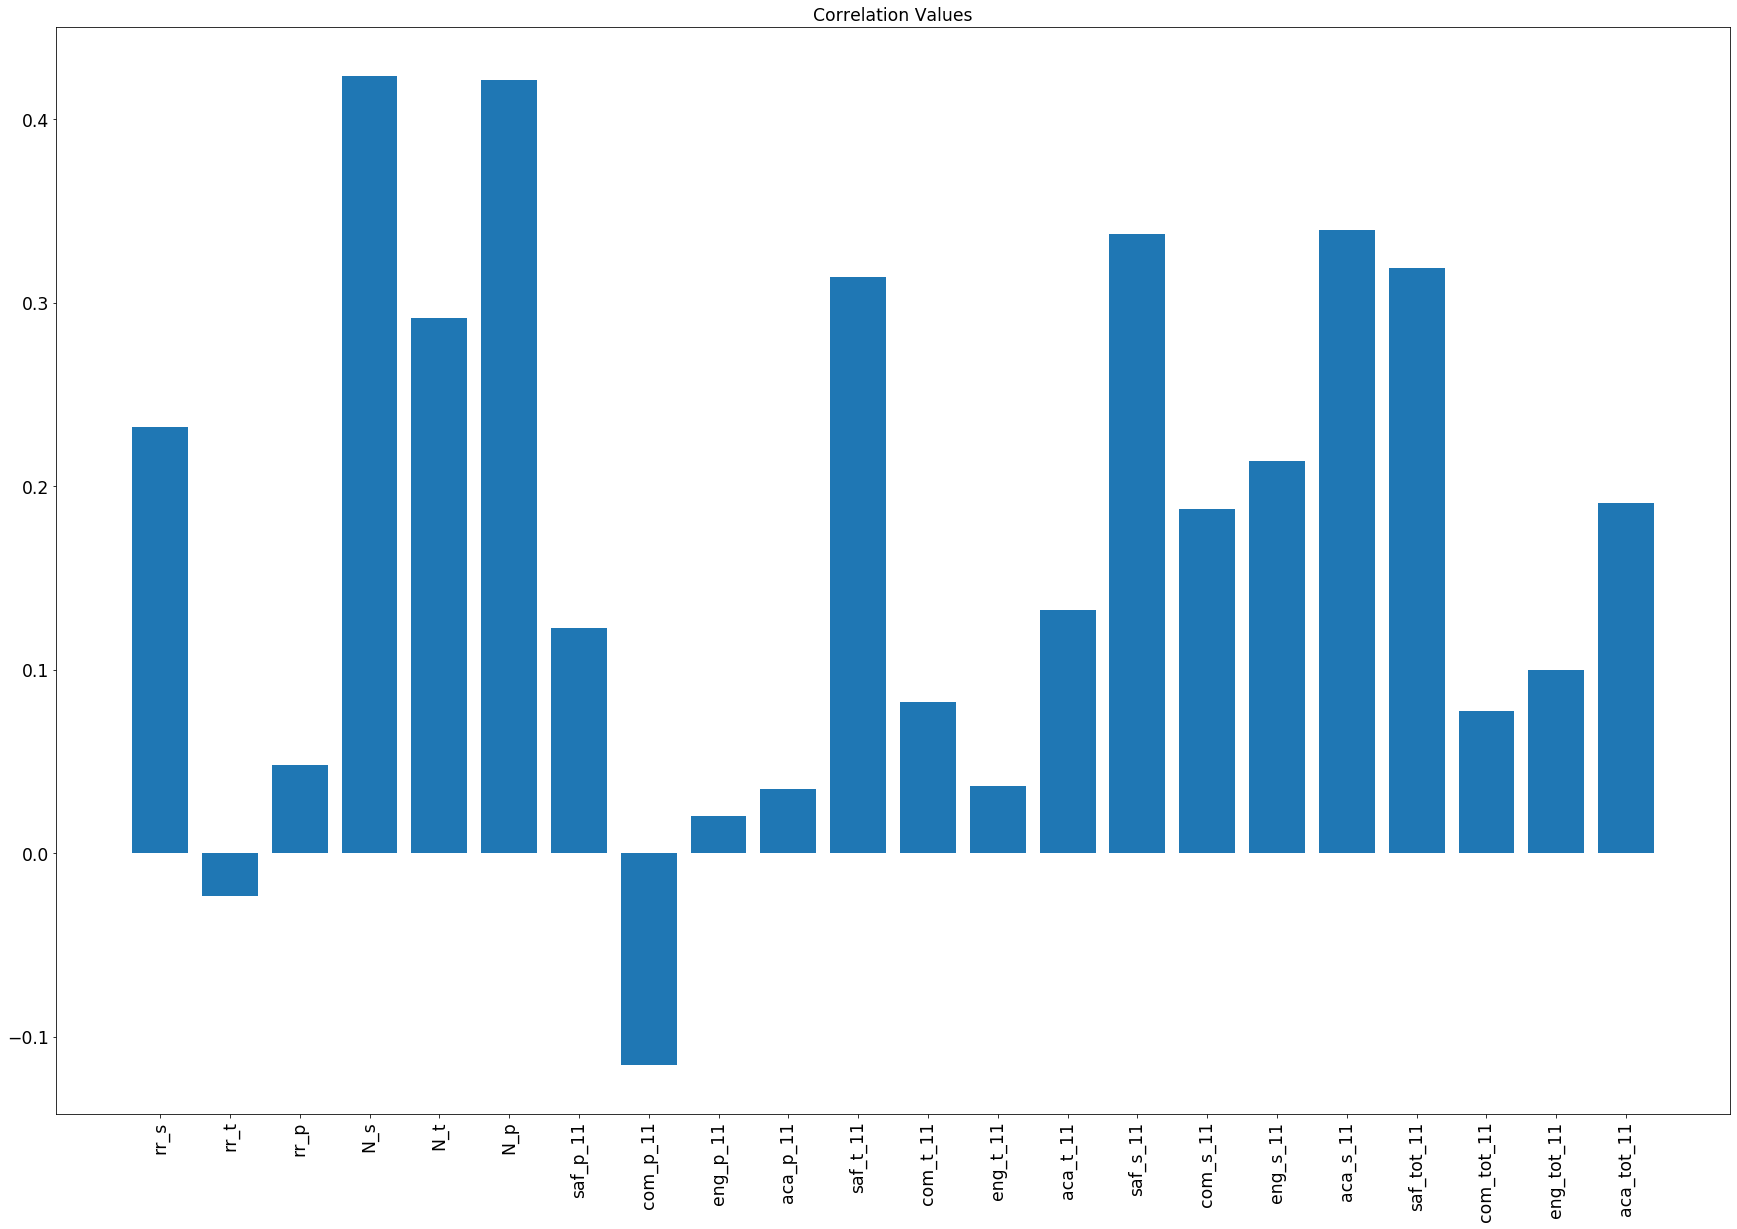

In [11]:
plot_series = correlations.loc[survey_list]
bar_position = np.arange(len(plot_series)) + 0.75
fig,ax = plt.subplots(figsize = (30,20))
ax.bar(bar_position,plot_series)
ax.set_title('Correlation Values', fontsize = 'xx-large')
ax.set_xticks(bar_position)
ax.set_xticklabels(plot_series.index, rotation = 90, fontsize = 'xx-large')
plt.yticks(fontsize = 'xx-large')
plt.show()

# Observations On sat_score Correlations
<br><br>
- The number of student, parent and teacher respondents have significantly positive correlation values; which could mean that when parents, students and teachers give more feedback the students are more likely to be successful.
<br><br>
- The total safety and respect score was the most positively correlated amongst the total scores; which could indicate that when teachers, students and teachers all feel safe and respected the students are more likely to be successful.
<br><br>
- The safety and respect score according to parents responses was the least positively correlated amongst all safety and respect scores, which indicates that the parents feeling safe and respected has the least impact to student success compared to teachers and students feeling safe and respected.
<br><br>
- The academic expectation scores based on student responses was also positively correlated, this indicates that having high academic expectations could lead to higher probabaility of success for a student.

As noted above the highest contribution to the total safety and respect scores was that of the parents and teachers, so that will be further analysed with a scatterplot.


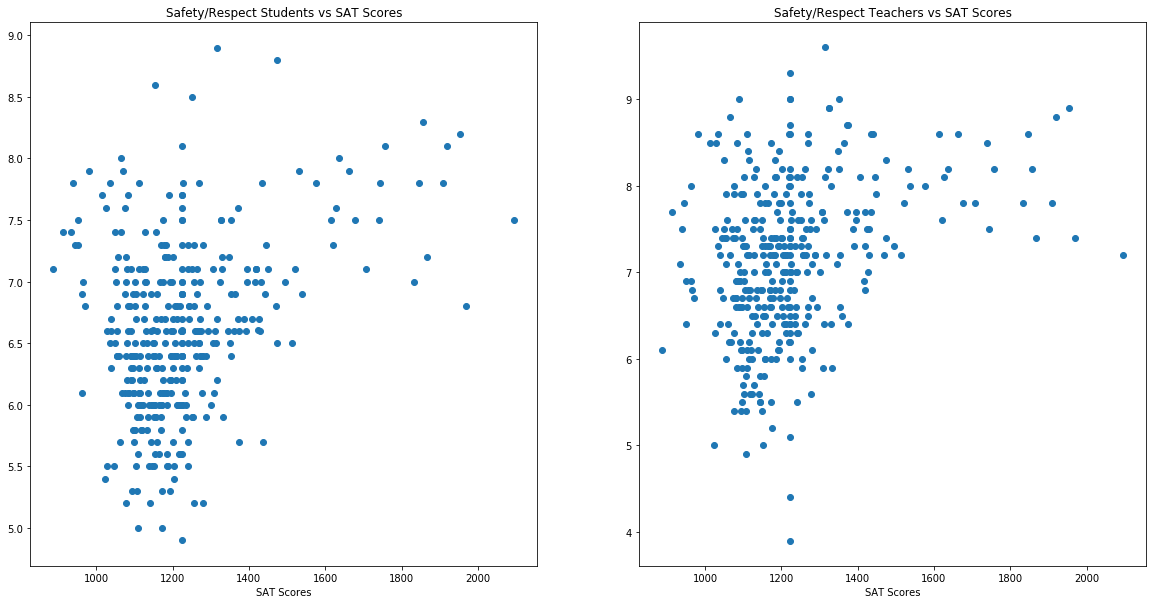

In [12]:
fig,(ax, ax1) = plt.subplots(1,2,figsize = (20,10))
ax.scatter(combined['sat_score'], combined['saf_s_11'])
ax1.scatter(combined['sat_score'], combined['saf_t_11'])
ax.set_xlabel('SAT Scores')
ax1.set_xlabel('SAT Scores')
ax.set_title('Safety/Respect Students vs SAT Scores')
ax1.set_title('Safety/Respect Teachers vs SAT Scores')
plt.show()

In the scatterplots above there isn't much of a correlation when the SAT scores are between 1000 and 1400, but some correlation can be seen as the scores increase from 1400 to 2000.
This means some other variable or group of variables is largely responsible for the variations we see in  SAT scores.


# Bar Plot of Demographic Correlations

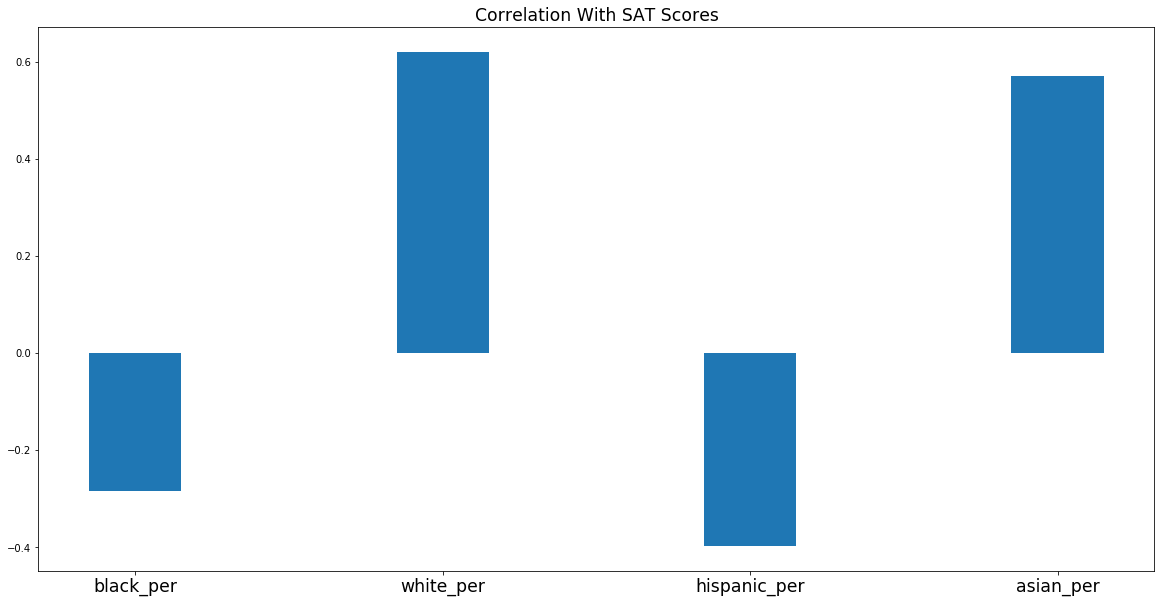

In [13]:
demographics =['black_per', 'white_per', 'hispanic_per', 'asian_per']
plot_series = correlations.loc[demographics]
bar_position = np.arange(len(plot_series)) + 0.75
fig,ax = plt.subplots(figsize = (20,10))
ax.bar(bar_position,plot_series, width = 0.3)
ax.set_title('Correlation With SAT Scores', fontsize = 'xx-large')
ax.set_xticks(bar_position)
ax.set_xticklabels(plot_series.index, fontsize = 'xx-large')
plt.show()

# Explore sat_score and hispanic_per Relationship

In [14]:
hispanic_per_high = combined.loc[(combined['sat_score'] < 1200) & (combined['hispanic_per'] > 50),\
        ['SCHOOL NAME', 'sat_score', 'hispanic_per']].sort_values('hispanic_per', ascending = False)
hispanic_per_high.iloc[:10,:]


,SCHOOL NAME,sat_score,hispanic_per
286,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,951.0,100.0
44,MANHATTAN BRIDGES HIGH SCHOOL,1058.0,99.8
89,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,1014.0,99.8
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,970.0,99.8
253,MULTICULTURAL HIGH SCHOOL,887.0,99.8
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,934.0,99.8
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,951.0,99.4
82,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,1174.0,96.7
81,COMMUNITY HEALTH ACADEMY OF THE HEIGHTS,1105.0,93.8
84,HIGH SCHOOL FOR INTERNATIONAL BUSINESS AND FIN...,1127.0,91.4


In [15]:
hispanic_per_low = combined.loc[(combined['sat_score'] > 1800) & (combined['hispanic_per'] < 50),\
        ['SCHOOL NAME', 'sat_score', 'hispanic_per']].sort_values('hispanic_per')

hispanic_per_low

,SCHOOL NAME,sat_score,hispanic_per
37,STUYVESANT HIGH SCHOOL,2096.0,2.4
356,STATEN ISLAND TECHNICAL HIGH SCHOOL,1953.0,5.3
151,BRONX HIGH SCHOOL OF SCIENCE,1969.0,7.2
187,BROOKLYN TECHNICAL HIGH SCHOOL,1833.0,7.9
327,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,1868.0,7.9
302,TOWNSEND HARRIS HIGH SCHOOL,1910.0,12.9
155,HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE,1920.0,18.0
5,BARD HIGH SCHOOL EARLY COLLEGE,1856.0,18.2
79,"HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...",1847.0,21.2


# Scatterplot of hispanic_per Relationship

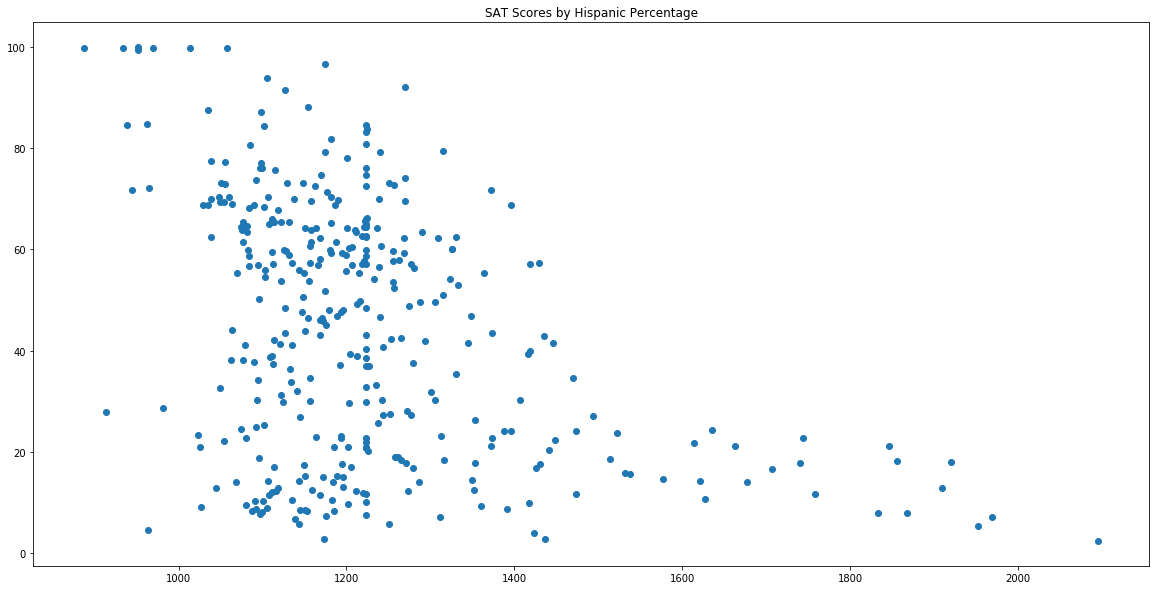

In [16]:
fig,ax = plt.subplots(figsize = (20,10))
ax.set_title('SAT Scores by Hispanic Percentage')
ax.scatter(combined['sat_score'], combined['hispanic_per'])
plt.show()

# Observations
 
 <br><br>
- Exploring the schools with a high percentage of hispanic students,I decided to look at <font size = 2px>PAN AMERICAN INTERNATIONAL HIGH SCHOOL</font> with 100 percent hispanic students. According to this <a href = 'https://insideschools.org/school/24Q296'> website </a> Pan American has improved academically since 2015, which was 4 years after the survey we got our data from. It improved because the new principal did things like meeting one on one with struggling students, encouraged attendance and encouraged speaking English.
<br><br>
- Exploring the schools with a low percentage of hispanic students,I decided to look at <font size = 2px>STUYVESANT HIGH SCHOOL</font>  with 2.4 percent hispanic students. Stuyvesant High School is a publicly funded school in the Manhattan area (District 2), it has very limited seating for admission and a high admission requirement. The reason that students that go to this  <a href = 'https://insideschools.org/school/02M475'> school </a> are so successful in their SAT's, is because they were already highly engaged and motivated students before admission into the school; as well they have a lot of academic activities such as high level math competitions that push them to even higher levels. According to a 2010  <a href = "https://www1.nyc.gov/assets/planning/download/pdf/data-maps/nyc-population/census2010/pgrhc.pdf"> survey </a> Manhattan had a hispanic population percentage of 27.2, this suggests that the 2.4 percent admission for hispanic students is due to factors other than population.
<br><br>
- According to our scatterplot above, there isn't much of a correlation with hispanic percentage for SAT scores under 1400, however there is significant negative correlation above 1400. But as has been observed there are other factors at play, factors such as student engagement seem to have a stronger direct impact on student success.

# Gender Correlation With SAT Scores

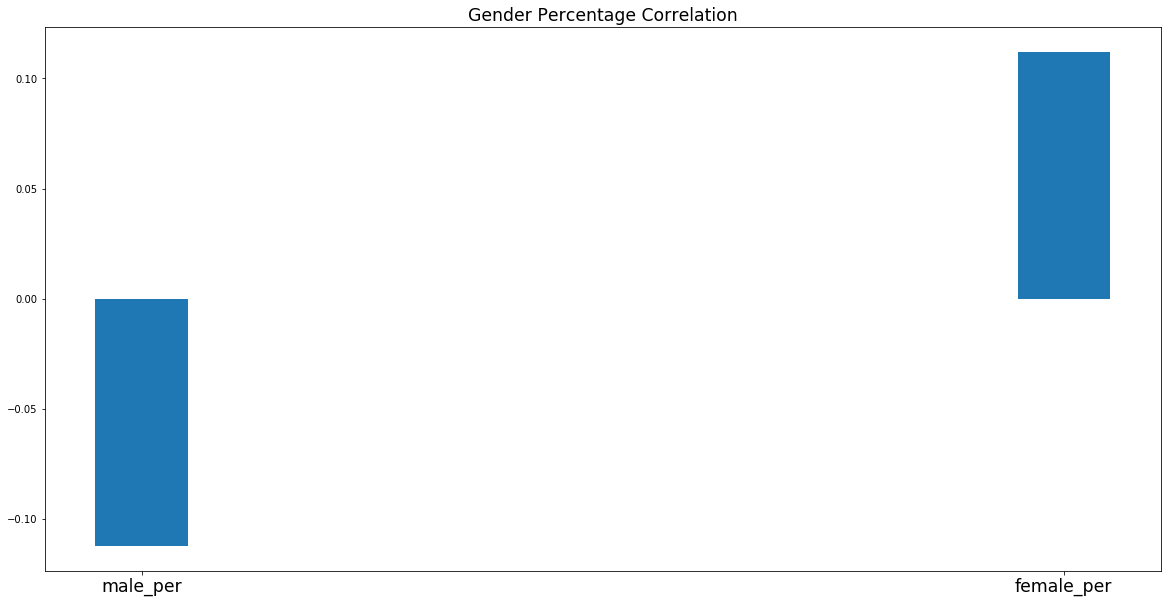

In [17]:
fig,ax = plt.subplots(figsize = (20,10))
plot_series = correlations.loc[['male_per', 'female_per']]
bar_position = np.arange(len(plot_series)) + 0.75
ax.bar(bar_position,plot_series, width = 0.1)
ax.set_xticks(bar_position)
ax.set_title('Gender Percentage Correlation', fontsize = 'xx-large')
ax.set_xticklabels(plot_series.index, fontsize = 'xx-large')
plt.show()

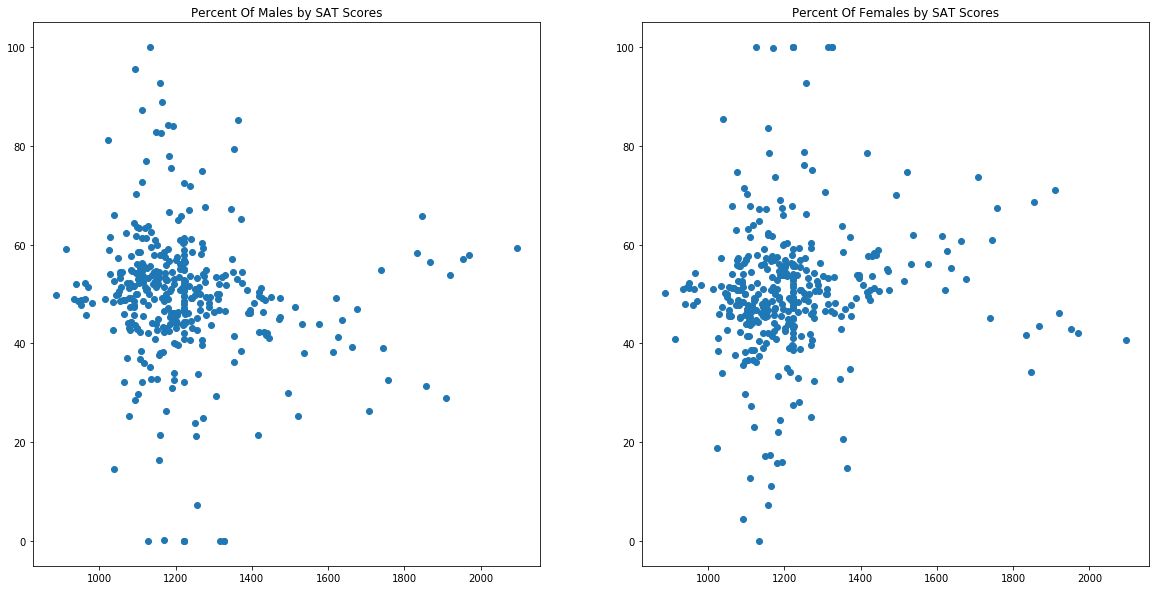

In [18]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize = (20,10))
ax1.scatter(combined['sat_score'], combined['male_per'])
ax1.set_title('Percent Of Males by SAT Scores')
ax2.scatter(combined['sat_score'], combined['female_per'])
ax2.set_title('Percent Of Females by SAT Scores')
plt.show()

In [19]:
female_per_high = combined.loc[(combined['sat_score'] > 1700) & (combined['female_per'] > 65),\
        ['SCHOOL NAME', 'sat_score', 'female_per']].sort_values('female_per', ascending = False)
female_per_high.iloc[:10,:]
 

,SCHOOL NAME,sat_score,female_per
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,1707.0,73.6
302,TOWNSEND HARRIS HIGH SCHOOL,1910.0,71.1
5,BARD HIGH SCHOOL EARLY COLLEGE,1856.0,68.7
26,ELEANOR ROOSEVELT HIGH SCHOOL,1758.0,67.5


# Observations
<br><br>
- As expected there is a weak correlation between gender percentages and SAT scores according to the scatter and bar plots, this indicates that there probabaly is no real difference between genders in terms of performance.
<br><br>
- In the dataframe above <font size = 2px> TOWNSEND HARRIS HIGH SCHOOL </font> has an unusually high percent of females and  an excellent SAT average, interestingly though this <a href = 'https://insideschools.org/school/25Q525'>school</a> is similar to Stuyvesant High School covered earlier. They only admit students with high grades that are highly motivated and engaged, and they keep the students engaged by offering academic activities not typical of high schools that are meant to challenge the students to greater heights. Because the percent of females has a weak correlation with SAT scores, it can be concluded that factors that led to the high female percent have very little impact on student success.